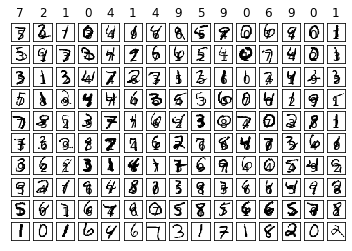

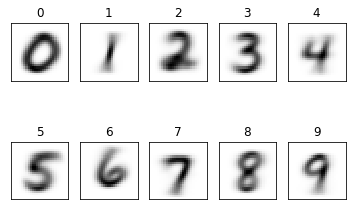

In [1]:
  import matplotlib.pyplot as plt
  import numpy as np

  file_data   = "mnist.csv"
  handle_file = open(file_data, "r")
  data        = handle_file.readlines()
  handle_file.close()

  size_row    = 28    # height of the image
  size_col    = 28    # width of the image

  num_image   = len(data)
  count       = 0     # count for the number of images

  #
  # normalize the values of the input data to be [0, 1]
  #
  def normalize(data):

      data_normalized = (data - min(data)) / (max(data) - min(data))

      return(data_normalized)

  #
  # example of distance function between two vectors x and y
  #
  def distance(x, y):

      d = (x - y) ** 2
      s = np.sum(d)
      # r = np.sqrt(s)

      return(s)

  #
  # make a matrix each column of which represents an images in a vector form
  #
  list_image  = np.empty((size_row * size_col, num_image), dtype=float)
  list_label  = np.empty(num_image, dtype=int)

  for line in data:

      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      list_label[count]       = label
      list_image[:, count]    = im_vector

      count += 1

  #
  # plot first 150 images out of 10,000 with their labels
  #
  f1 = plt.figure(1)

  for i in range(150):

      label       = list_label[i]
      im_vector   = list_image[:, i]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(10, 15, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)


  #plt.show()

  #
  # plot the average image of all the images for each digit
  #
  f2 = plt.figure(2)

  im_average  = np.zeros((size_row * size_col, 10), dtype=float)
  im_count    = np.zeros(10, dtype=int)

  for i in range(num_image):

      im_average[:, list_label[i]] += list_image[:, i]
      im_count[list_label[i]] += 1

  for i in range(10):

      im_average[:, i] /= im_count[i]

      plt.subplot(2, 5, i+1)
      plt.title(i)
      plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)

  plt.show()

In [2]:
from collections import OrderedDict


class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b

    return out
  
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis = 0)

    return dx
  
class sigmoid:
  def __init__(self):
    self.out = None

  def forward(self,x):
      out = 1 / (1 + np.exp(-x))
      self.out = out

      return out

  def backward(self,dout):
      dx = dout * (1.0 - self.out) * self.out

      return dx

class ThreeLayerNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.power(2/(input_size+hidden_size1), 1/2) * np.random.randn(input_size, hidden_size1) # xavier initialization
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = np.power(2/(hidden_size1+hidden_size2), 1/2) * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = np.power(2/(hidden_size2+output_size), 1/2) * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['sigmoid1'] = sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['sigmoid2'] = sigmoid()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['sigmoid3'] = sigmoid()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        t = np.int64(np.expand_dims(t, axis = 1))
        a = np.zeros((t.shape[0],10), dtype = int)
        for i in range(t.shape[0]):
          a[i,t[i]] = 1
        delta = 1e-7
        return -np.sum(a * np.log(y + delta) + (1-a) * np.log(1-y+delta)) / float(x.shape[0])
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
        
    def gradient(self, x, t):
        # forward
        self.predict(x)

        # backward
        dout = 1   
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

In [3]:
x_train = list_image[:, :6000].T
t_train = list_label[:6000]
x_test = list_image[:, 6000:].T
t_test = list_label[6000:]

In [4]:
network = ThreeLayerNet(input_size=784, hidden_size1=196, hidden_size2 = 49, output_size=10)
iters_num = 10000
train_size = x_train.shape[0]
learning_rate = 0.000001
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
decay = 0.001

for i in range(iters_num):
    
    grad = network.gradient(x_train, t_train) 
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    train_loss = network.loss(x_train, t_train)  
    test_loss = network.loss(x_test, t_test)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if i % 10 == 0:
        learning_rate = learning_rate * 1/(1 + decay)
        print(train_acc,test_acc,train_loss,test_loss)

0.09916666666666667 0.10375 6.7142430760022425 6.697643937477379
0.09916666666666667 0.10375 5.785838879491637 5.7675749162053656
0.09916666666666667 0.10375 5.0363924757704455 5.018078926754806
0.09916666666666667 0.10375 4.45933769816664 4.4422090011728885
0.09916666666666667 0.10375 4.035050076263728 4.019841882884901
0.09916666666666667 0.10375 3.7361322336252663 3.72315188789109
0.09916666666666667 0.10375 3.533940653078996 3.523216137271824
0.09916666666666667 0.10375 3.403178635872164 3.394589943014684
0.09916666666666667 0.10375 3.3237293777536463 3.317094269325178
0.09916666666666667 0.10375 3.28057862610341 3.2757000468418163
0.09916666666666667 0.10375 3.262912214974721 3.259601295580662
0.09916666666666667 0.10375 3.2630755432624805 3.261161038286123
0.09916666666666667 0.10375 3.275683558440794 3.2750144121495324
0.09916666666666667 0.10375 3.2969461297778144 3.2973908613568574
0.09916666666666667 0.10375 3.3241850286099384 3.325629834613201
0.09916666666666667 0.10375 3.3

0.12716666666666668 0.13625 5.449274764044191 5.4675520819104495
0.1275 0.13625 5.456814186579522 5.475118028377677
0.128 0.13625 5.464294534374595 5.482624608467109
0.128 0.137 5.471716652812429 5.490072672876645
0.1285 0.137 5.479081369535425 5.497463054427589
0.129 0.13675 5.48638949493236 5.504796568556103
0.1295 0.13675 5.493641822608981 5.5120740137880935
0.12933333333333333 0.13675 5.500839129842854 5.519296172198164
0.12966666666666668 0.1365 5.507982178023079 5.526463809853284
0.13 0.13675 5.515071713075469 5.533577677241768
0.13033333333333333 0.1365 5.522108465873764 5.540638509688135
0.13016666666666668 0.1365 5.5290931526374045 5.547647027754402
0.1305 0.1365 5.53602647531641 5.554603937628319
0.13066666666666665 0.13625 5.542909121963817 5.561509931499078
0.13033333333333333 0.136 5.549741767096187 5.568365687920927
0.13016666666666668 0.1365 5.55652507204262 5.575171872165204
0.1305 0.13675 5.563259685282688 5.581929136561167
0.13083333333333333 0.13675 5.569946242773751

0.13966666666666666 0.1215 6.155492574594267 6.175929689597912
0.13983333333333334 0.12125 6.158905320294381 6.179351453730474
0.13983333333333334 0.12125 6.162303814656765 6.1827589166676935
0.13966666666666666 0.12125 6.1656881611977905 6.186152182367005
0.13966666666666666 0.12125 6.169058462324377 6.189531353670911
0.13983333333333334 0.121 6.1724148193497 6.1928965323227985
0.13983333333333334 0.1215 6.175757332508654 6.196247818982469
0.13983333333333334 0.1215 6.179086100973022 6.199585313241394
0.14 0.121 6.182401222866384 6.202909113637715
0.14083333333333334 0.12075 6.1857027952787735 6.206219317670979
0.14116666666666666 0.1205 6.188990914281077 6.209516021816602
0.1415 0.12 6.192265674939178 6.212799321540115
0.14166666666666666 0.11975 6.195527171327866 6.216069311311132
0.14183333333333334 0.11975 6.198775496544496 6.2193260846170935
0.14183333333333334 0.11925 6.202010742722433 6.222569733976774
0.14166666666666666 0.11925 6.2052330010442445 6.225800350953559
0.1415 0.11

0.1395 0.1075 6.528639308984424 6.549992776524377
0.1395 0.1075 6.530730309604735 6.5520885311306465
0.1395 0.10725 6.532815110152223 6.554178067497846
0.1395 0.10725 6.534893740955471 6.556261416061949
0.13966666666666666 0.10725 6.536966232125203 6.558338607040187
0.13983333333333334 0.10725 6.539032613556358 6.560409670433128
0.13983333333333334 0.10725 6.541092914930135 6.562474636026744
0.13983333333333334 0.10725 6.5431471657160305 6.564533533394441
0.13983333333333334 0.10725 6.545195395173821 6.566586391899062
0.13983333333333334 0.10725 6.547237632355561 6.568633240694892
0.13983333333333334 0.1075 6.54927390610752 6.570674108729602
0.13983333333333334 0.10725 6.551304245072131 6.572709024746202
0.13983333333333334 0.10725 6.553328677689886 6.574738017284956
0.14 0.107 6.5553472322012265 6.576761114685272
0.14 0.10675 6.557359936648415 6.578778345087584
0.13983333333333334 0.107 6.559366818877371 6.580789736435199
0.13983333333333334 0.107 6.561367906539499 6.582795316476122
0

0.14016666666666666 0.10275 6.7705228236163615 6.792399665574605
0.13983333333333334 0.10275 6.771970862378327 6.7938506794278934
0.13983333333333334 0.10275 6.773415471858741 6.795298255115856
0.13983333333333334 0.10275 6.774856664800473 6.796742405421184
0.13983333333333334 0.103 6.776294453877458 6.798183143057397
0.13983333333333334 0.103 6.777728851695214 6.799620480669345
0.13983333333333334 0.103 6.779159870791309 6.801054430833702
0.13983333333333334 0.103 6.780587523635873 6.802485006059445
0.13983333333333334 0.10275 6.782011822632056 6.803912218788348
0.14 0.10275 6.783432780116518 6.8053360813954455
0.13983333333333334 0.10275 6.784850408359901 6.806756606189526
0.13983333333333334 0.10275 6.786264719567292 6.808173805413588
0.14016666666666666 0.10275 6.787675725878689 6.809587691245316
0.14033333333333334 0.103 6.789083439369468 6.810998275797534
0.14033333333333334 0.103 6.79048787205083 6.812405571118665
0.14033333333333334 0.10275 6.791889035870258 6.813809589193196
0

0.13683333333333333 0.099 6.943630656167699 6.965850254994296
0.13683333333333333 0.09925 6.944699983870758 6.966921620125929
0.13683333333333333 0.09925 6.945767158120631 6.967990826735996
0.13683333333333333 0.09925 6.946832185411478 6.969057881337063
0.13666666666666666 0.0995 6.947895072209287 6.970122790413448
0.13666666666666666 0.0995 6.948955824952046 6.9711855604213655
0.1365 0.099 6.950014450049887 6.972246197789085
0.13666666666666666 0.099 6.951070953885255 6.9733047089171105
0.13666666666666666 0.099 6.952125342813066 6.974361100178316
0.13666666666666666 0.099 6.953177623160865 6.975415377918122
0.13666666666666666 0.099 6.954227801228982 6.976467548454637
0.13666666666666666 0.099 6.955275883290683 6.97751761807883
0.13666666666666666 0.099 6.956321875592328 6.978565593054668
0.13683333333333333 0.099 6.957365784353528 6.9796114796192885
0.13683333333333333 0.09925 6.958407615767286 6.9806552839831335
0.13666666666666666 0.09925 6.959447376000162 6.9816970123301125
0.136

0.13566666666666666 0.099 7.074094480916436 7.096555573101864
0.13566666666666666 0.099 7.074916446824287 7.097379015616985
0.13566666666666666 0.099 7.07573694872814 7.098200990942623
0.13566666666666666 0.099 7.0765559903683535 7.099021502828911
0.13566666666666666 0.099 7.077373575471735 7.099840555012391
0.13566666666666666 0.099 7.078189707751603 7.100658151216073
0.1355 0.099 7.079004390907856 7.101474295149511
0.1355 0.099 7.079817628627032 7.102288990508856
0.1355 0.09925 7.080629424582378 7.103102240976932
0.1355 0.09925 7.0814397824339155 7.103914050223286
0.1355 0.09925 7.082248705828483 7.10472442190426
0.1355 0.09925 7.083056198399833 7.105533359663059
0.1355 0.09925 7.083862263768666 7.106340867129796
0.1355 0.09925 7.0846669055427025 7.107146947921572
0.1355 0.09925 7.085470127316748 7.107951605642533
0.1355 0.09925 7.086271932672748 7.108754843883925
0.1355 0.09925 7.087072325179856 7.109556666224159
0.1355 0.09925 7.087871308394485 7.110357076228876
0.13583333333333333

0.13583333333333333 0.0995 7.178356656658343 7.201000633561119
0.13583333333333333 0.0995 7.179001710318571 7.201646791185365
0.13583333333333333 0.0995 7.1796457228784005 7.202291905592225
0.13583333333333333 0.0995 7.180288696652665 7.2029359791021585
0.13583333333333333 0.0995 7.180930633949017 7.203579014028426
0.13583333333333333 0.0995 7.1815715370679625 7.204221012677118
0.13583333333333333 0.0995 7.182211408302889 7.204861977347186
0.13583333333333333 0.0995 7.182850249940093 7.205501910330468
0.13583333333333333 0.0995 7.183488064258808 7.2061408139117304
0.136 0.0995 7.184124853531239 7.206778690368678
0.13616666666666666 0.0995 7.184760620022583 7.207415541971997
0.13616666666666666 0.0995 7.185395365991063 7.208051370985377
0.13616666666666666 0.0995 7.186029093687958 7.208686179665543
0.13616666666666666 0.0995 7.186661805357628 7.209319970262283
0.13616666666666666 0.0995 7.187293503237534 7.2099527450184695
0.13616666666666666 0.0995 7.187924189558285 7.210584506170102
0

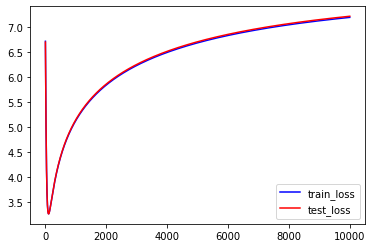

In [6]:
a = [i for i in range(10000)]
plt.plot(a, train_loss_list,label = 'train_loss', c = 'b')
plt.plot(a, test_loss_list,label = 'test_loss', c = 'r')
plt.legend()
plt.show()

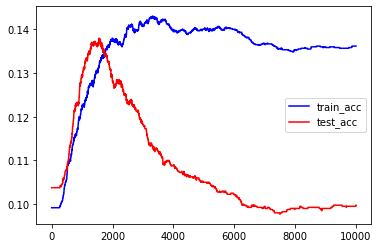

In [7]:
plt.plot(a, train_acc_list,label = 'train_acc', c = 'b')
plt.plot(a, test_acc_list,label = 'test_acc', c = 'r')
plt.legend()
plt.show()